## Housecleaning

### Importing Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from itertools import combinations
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

### Data Preparation

In [3]:
# Set the new working directory
new_path = 'C:/Users/1412r/Customer Segmentation'
os.chdir(new_path)

In [5]:
# Load dataset
df = pd.read_csv('data.csv',encoding="ISO-8859-1", dtype={'CustomerID': str,'InvoiceID': str})

# Initial shape
print(f"Initial shape: {df.shape}")

Initial shape: (541909, 8)


In [24]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [7]:
# Remove null objects from CustomerID and Description columns
# Drop rows with missing CustomerID
df.dropna(subset=['CustomerID'], inplace=True)

# Remove duplicates
df.drop_duplicates(inplace=True)

In [8]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Optional: Create a new column for InvoiceMonth
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')

# Convert CustomerID to string (helps when merging or plotting later)
df['CustomerID'] = df['CustomerID'].astype(str)

# Final shape
print(f"Cleaned shape: {df.shape}")

Cleaned shape: (401604, 10)


In [11]:
# Clean Description column - Convert to lowercase and strip whitespace
df['Description'] = df['Description'].str.lower().str.strip()

In [13]:
# Basic overview
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 401604 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   InvoiceNo     401604 non-null  object        
 1   StockCode     401604 non-null  object        
 2   Description   401604 non-null  object        
 3   Quantity      401604 non-null  int64         
 4   InvoiceDate   401604 non-null  datetime64[ns]
 5   UnitPrice     401604 non-null  float64       
 6   CustomerID    401604 non-null  object        
 7   Country       401604 non-null  object        
 8   TotalPrice    401604 non-null  float64       
 9   InvoiceMonth  401604 non-null  period[M]     
dtypes: datetime64[ns](1), float64(2), int64(1), object(5), period[M](1)
memory usage: 33.7+ MB
None
            Quantity                    InvoiceDate      UnitPrice  \
count  401604.000000                         401604  401604.000000   
mean       12.183273  2011-07-10 12:08:23

1. Negative and equal in value quantity suggests returned/cancelled orders => returns analysis is additionally required
2. Zero unit price suggests transaction or inventory adjustments, which are not required for analysis or segmentation => remove them 

In [15]:
# Check out the number of returns and adjustments
rows, columns = df[df['Quantity']<=0].shape
print(f"Number of returns or cancellations: {rows}")

rows, columns = df[df['UnitPrice']==0].shape
print(f"Number of adjustments: {rows}")

Number of returns or cancellations: 8872
Number of adjustments: 40


In [17]:
# Remove rows with non-positive unit prices
df = df[df['UnitPrice'] > 0]

In [19]:
# Looking deeper into rows with suspiciously high unit price
df.sort_values('UnitPrice', ascending=False, inplace=True)
df.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceMonth
222681,C556445,M,manual,-1,2011-06-10 15:31:00,38970.0,15098,United Kingdom,-38970.0,2011-06


In [21]:
# Filter rows where StockCode contains only letters (no digits)
alpha_stockcodes = df[df['StockCode'].str.match(r'^[A-Za-z]+$', na=False)]

# Display unique values of such StockCodes along with their descriptions
unique_alpha_codes = alpha_stockcodes[['StockCode', 'Description']].drop_duplicates()

# Show them
print(unique_alpha_codes.sort_values('StockCode'))

       StockCode                 Description
528087      CRUK             cruk commission
150591         D                    discount
528082       DOT              dotcom postage
222681         M                      manual
279045      PADS  pads to match all cushions
173382      POST                     postage


In [23]:
# Remove non-product codes
non_product_codes = ['CRUK', 'D', 'DOT', 'M', 'POST']
df = df[~df['StockCode'].isin(non_product_codes)]
df.shape

(399805, 10)

In [25]:
# Remove large cancellations
# Add absolute quantity column for sorting
df['abs_qty'] = df['Quantity'].abs()

# Sort and select top 2 largest quantity rows (positive only)
top2 = df[df['Quantity'] > 0].sort_values(by='abs_qty', ascending=False).head(2)

# Create a mask for matching return (negative quantity) rows
cancel_pairs = []
for _, row in top2.iterrows():
    match = df[
        (df['CustomerID'] == row['CustomerID']) &
        (df['StockCode'] == row['StockCode']) &
        (df['Quantity'] == -row['Quantity'])
    ]
    if not match.empty:
        cancel_pairs.extend([row.name, match.index[0]])

# Drop the matched rows
df = df.drop(cancel_pairs).drop(columns='abs_qty')

### Exploratory Analysis

In [27]:
# Basic overview
print('Basic Overview', '\n\n')
print(df.describe(), '\n\n')

# Unique values
print(f"Unique customers: {df['CustomerID'].nunique()}")
print(f"Unique products: {df['StockCode'].nunique()}")
print(f"Unique invoices: {df['InvoiceNo'].nunique()}")
print(f"Unique Countries: {df['Country'].nunique()}", '\n\n')

# Top 5 countries by number of transactions
print(df['Country'].value_counts().head(), '\n\n')

# Total revenue
total_revenue = df['TotalPrice'].sum()
print(f"Total Revenue: £{total_revenue:,.2f}", '\n\n')

# Top 5 selling products
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head()
print("Top 5 selling products:\n", top_products, '\n\n')

# Revenue by country (excluding UK if needed)
revenue_by_country = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)
print("Revenue by country:\n", revenue_by_country.head(), '\n\n')

# Monthly revenue trend
monthly_revenue = df.set_index('InvoiceDate').resample('M')['TotalPrice'].sum()
print("Monthly revenue:\n", monthly_revenue, '\n\n')

# Avg order value per invoice
avg_order_value = df.groupby('InvoiceNo')['TotalPrice'].sum().mean()
print(f"Average Order Value: £{avg_order_value:.2f}")

Basic Overview 


            Quantity                    InvoiceDate      UnitPrice  \
count  399801.000000                         399801  399801.000000   
mean       12.191618  2011-07-10 12:36:16.066693120       2.923843   
min     -9360.000000            2010-12-01 08:26:00       0.001000   
25%         2.000000            2011-04-06 15:31:00       1.250000   
50%         5.000000            2011-07-29 15:51:00       1.950000   
75%        12.000000            2011-10-20 12:03:00       3.750000   
max      4800.000000            2011-12-09 12:50:00     649.500000   
std        46.239439                            NaN       4.538178   

          TotalPrice  
count  399801.000000  
mean       20.690989  
min     -6539.400000  
25%         4.250000  
50%        11.580000  
75%        19.500000  
max     38970.000000  
std        96.075910   


Unique customers: 4361
Unique products: 3678
Unique invoices: 21795
Unique Countries: 37 


Country
United Kingdom    356131
Germany         

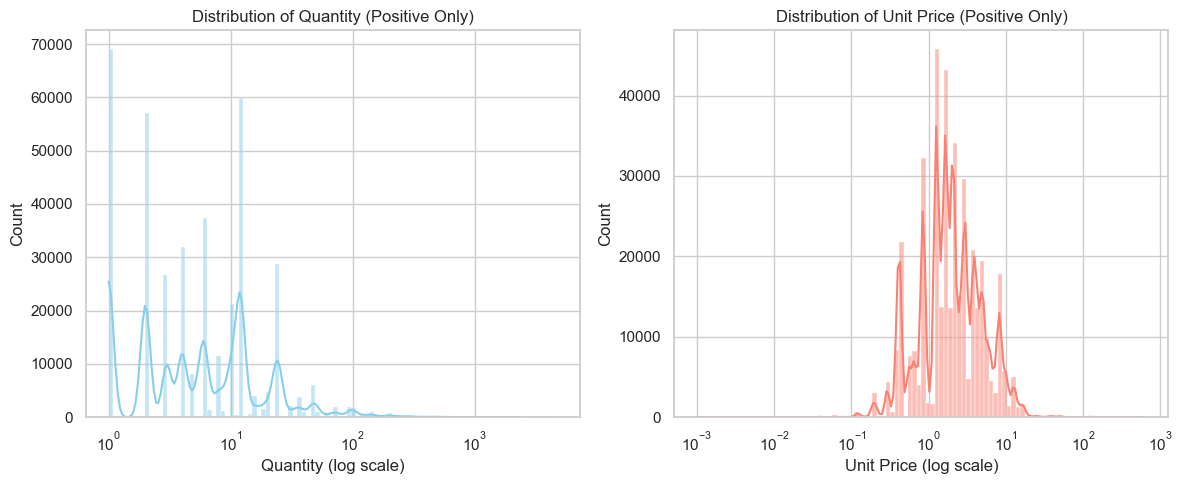

In [29]:
# Histograms of quantity and unit price
# Set up the visual style
sns.set(style="whitegrid")

# Histogram for Quantity
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(data=df[df['Quantity'] > 0], x='Quantity', bins=100, kde=True, log_scale=(True, False), color='skyblue')
plt.title('Distribution of Quantity (Positive Only)')
plt.xlabel('Quantity (log scale)')
plt.ylabel('Count')

# Histogram for Unit Price
plt.subplot(1, 2, 2)
sns.histplot(data=df[df['UnitPrice'] > 0], x='UnitPrice', bins=100, kde=True, log_scale=(True, False), color='salmon')
plt.title('Distribution of Unit Price (Positive Only)')
plt.xlabel('Unit Price (log scale)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

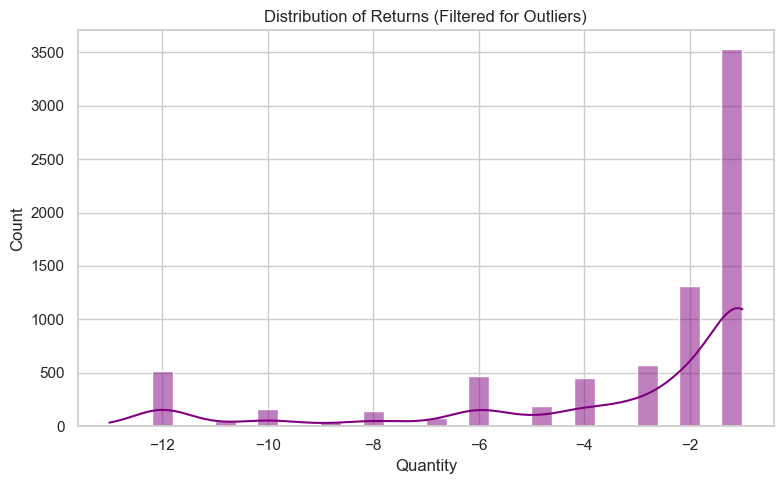

In [31]:
# Histogram of Returns excluding outliers (Negative Quantity)
# Filter only returns (Quantity < 0)
returns = df[df['Quantity'] < 0].copy()

# Remove outliers using IQR
Q1 = returns['Quantity'].quantile(0.25)
Q3 = returns['Quantity'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Keep only non-outliers
returns_filtered = returns[(returns['Quantity'] >= lower_bound) & (returns['Quantity'] <= upper_bound)]

# Plot histogram
plt.figure(figsize=(8, 5))
sns.histplot(returns_filtered['Quantity'], bins=30, kde=True, color='purple')
plt.title('Distribution of Returns (Filtered for Outliers)')
plt.xlabel('Quantity')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## Data Visualization

### Country wise top 3 products

In [33]:
# Top 10 countries (excluding UK)
top_countries = df['Country'].value_counts().head(10).index

# Group by country and product
top_country_products = (
    df[df['Country'].isin(top_countries)]
    .groupby(['Country', 'Description'])['Quantity']
    .sum()
    .reset_index()
)
top_country_products['Quantity'] = np.log(top_country_products['Quantity'])

# Get top 3 products per country
top_n = top_country_products.sort_values(['Country', 'Quantity'], ascending=[True, False])\
    .groupby('Country').head(5)

top_n.sort_values('Quantity', ascending=False, inplace=True)

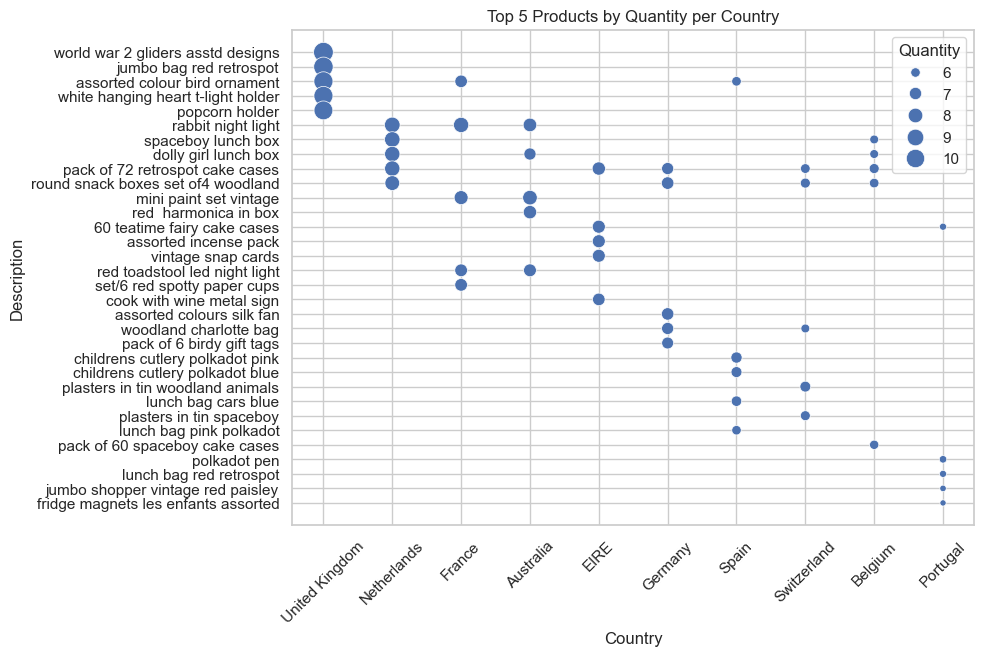

In [35]:
# Plot
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=top_n, x='Country', y='Description', size='Quantity',
    sizes=(20, 200)
)
plt.title('Top 5 Products by Quantity per Country')
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

### Product Correlation Map

In [37]:
# Basket matrix: invoices × products (binary)
# Top 100 most frequently purchased products
top_products = (df[df['Quantity'] > 0]
                .groupby('Description')['InvoiceNo']
                .nunique()
                .sort_values(ascending=False)
                .head(100)
                .index)

# Filter dataset to only include those products
filtered_df = df[df['Description'].isin(top_products)]

# Convert to binary: 1 if bought, else 0
basket = (filtered_df
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum()
          .unstack()
          .fillna(0)
          .applymap(lambda x: 1 if x > 0 else 0))

# Compute product-wise correlation
product_names = basket.columns
basket_np = basket.values

# Compute correlation matrix (Pearson)
correlation_matrix = np.corrcoef(basket_np.T)

# Convert to DataFrame
corr_df = pd.DataFrame(correlation_matrix, index=product_names, columns=product_names)

# Filter for strong correlations
filtered_corr = corr_df[(corr_df > 0.5) & (corr_df < 1.0)].dropna(axis=0, how='all').dropna(axis=1, how='all')

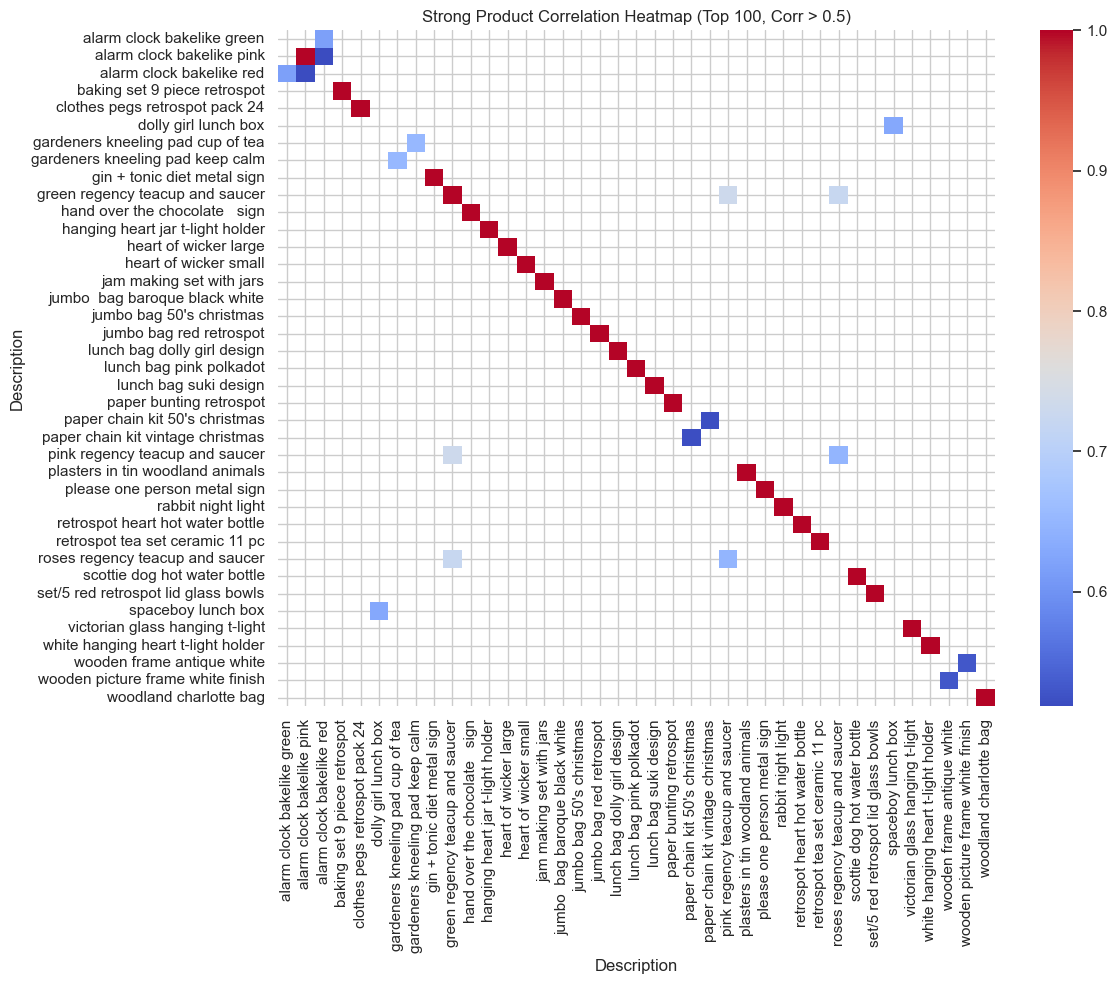

In [39]:
# Plot heatmap
plt.figure(figsize=(12,10))
sns.heatmap(filtered_corr, cmap='coolwarm', annot=False)
plt.title('Strong Product Correlation Heatmap (Top 100, Corr > 0.5)')
plt.tight_layout()
plt.show()

### Country-wise Customer Behaviour Patterns

In [41]:
# Function to remove outliers
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out outliers
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return filtered_df

In [75]:
# Function to create boxplot
def create_boxplot(df, CustomerID, Country, InvoiceNo_or_Description, TotalPrice, Quantity):
    
    # Pivot prep
    if InvoiceNo_or_Description == 'InvoiceNo':
        customer_stats = df.groupby(['CustomerID', 'Country']).agg({
            'InvoiceNo': 'nunique',
            'TotalPrice': 'sum'
        }).reset_index().rename(columns={'InvoiceNo': 'temp'})
        
    if InvoiceNo_or_Description == 'Description':
        customer_stats = df.groupby(['CustomerID', 'Country']).agg({
            'Quantity': 'sum',
            'TotalPrice': 'sum'
        }).reset_index().rename(columns={'Quantity': 'temp'})
    
    customer_stats['AvgValue'] = customer_stats['TotalPrice'] / customer_stats['temp']

    # All countries
    top_countries = df['Country'].value_counts().head(37).index
    filtered = customer_stats[customer_stats['Country'].isin(top_countries)]

    # Remove outliers
    filtered = remove_outliers_iqr(filtered, 'AvgValue')

    # AOV Boxplot
    plt.figure(figsize=(10,6))
    sns.boxplot(data=filtered, x='Country', y='AvgValue')
    plt.xticks(rotation=90)
    plt.tight_layout()

In [96]:
# Function to create barplot
def create_barplot(df, InvoiceNo_or_Description='InvoiceNo'):
    if InvoiceNo_or_Description == 'InvoiceNo':
        # AOV per customer
        customer_stats = df.groupby(['CustomerID', 'Country']).agg({
            'InvoiceNo': 'nunique',
            'TotalPrice': 'sum'
        }).reset_index().rename(columns={'InvoiceNo': 'temp'})

        customer_stats['AvgValue'] = customer_stats['TotalPrice'] / customer_stats['temp']
        metric_name = "AOV"

    elif InvoiceNo_or_Description == 'Description':
        # Average item price per customer
        customer_stats = df.groupby(['CustomerID', 'Country']).agg({
            'Quantity': 'sum',
            'TotalPrice': 'sum'
        }).reset_index().rename(columns={'Quantity': 'temp'})

        customer_stats = customer_stats[customer_stats['temp'] > 0]  # Avoid division by zero
        customer_stats['AvgValue'] = customer_stats['TotalPrice'] / customer_stats['temp']
        metric_name = "Average Item Price"

    else:
        raise ValueError("Parameter must be either 'InvoiceNo' or 'Description'")

    # Remove outliers
    customer_stats = remove_outliers_iqr(customer_stats, 'AvgValue')

    # Median per country
    country_median = customer_stats.groupby('Country')['AvgValue'].median().reset_index()
    country_median.sort_values('AvgValue', ascending=False, inplace=True)
    # print(country_median)

    # Plot
    plt.figure(figsize=(15,6))
    sns.barplot(data=country_median, x='Country', y='AvgValue')
    plt.xticks(rotation=90)
    plt.title(f"Median {metric_name} per Country")
    plt.ylabel(metric_name)
    plt.xlabel("Country")
    plt.tight_layout()

               Country    AvgValue
15             Iceland  615.714286
9                 EIRE  546.885761
14              Greece  415.490000
19           Lithuania  415.265000
28         Switzerland  408.490000
1              Austria  381.980000
8              Denmark  380.960000
5      Channel Islands  363.530000
11             Finland  359.310000
6               Cyprus  320.690000
17               Italy  317.820000
24            Portugal  313.553333
22              Norway  294.400000
10  European Community  287.687500
13             Germany  276.840000
2              Bahrain  274.200000
31         Unspecified  273.032500
3              Belgium  263.990833
12              France  256.608571
23              Poland  250.990000
26               Spain  238.325000
18               Japan  229.640000
30      United Kingdom  221.642500
0            Australia  200.950000
29                 USA  191.975000
21         Netherlands  184.445000
27              Sweden  181.898333
7       Czech Republ

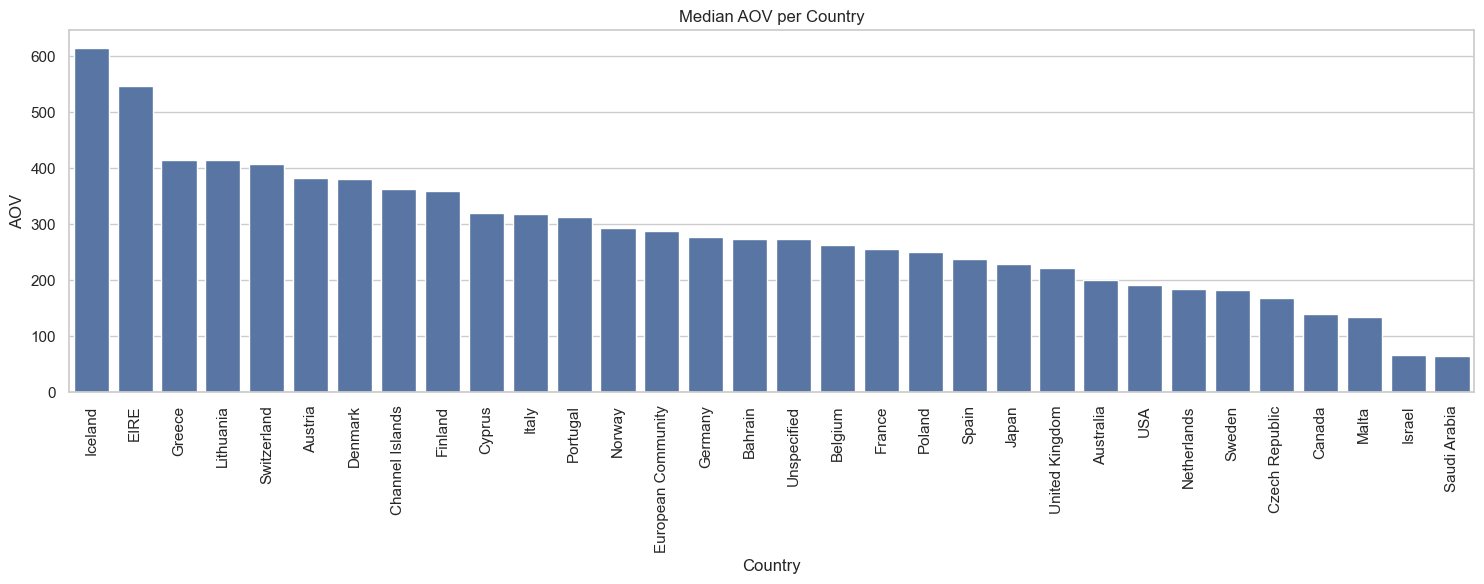

In [73]:
# Average Order Value by country
# AOV will be slightly distorted due to the double-counting of sale-return invoices; but not enough that needs time to be spent on recalculating correclty
create_barplot(df, 'InvoiceNo')
plt.show()

     CustomerID         Country  temp  TotalPrice    AvgValue
0         12347         Iceland     7     4310.00  615.714286
1         12348         Finland     4     1437.24  359.310000
3         12350          Norway     1      294.40  294.400000
4         12352          Norway     8     1265.41  158.176250
5         12353         Bahrain     1       89.00   89.000000
...         ...             ...   ...         ...         ...
4364      18280  United Kingdom     1      180.60  180.600000
4365      18281  United Kingdom     1       80.82   80.820000
4366      18282  United Kingdom     3      176.60   58.866667
4367      18283  United Kingdom    16     2039.58  127.473750
4368      18287  United Kingdom     3     1837.28  612.426667

[4081 rows x 5 columns]


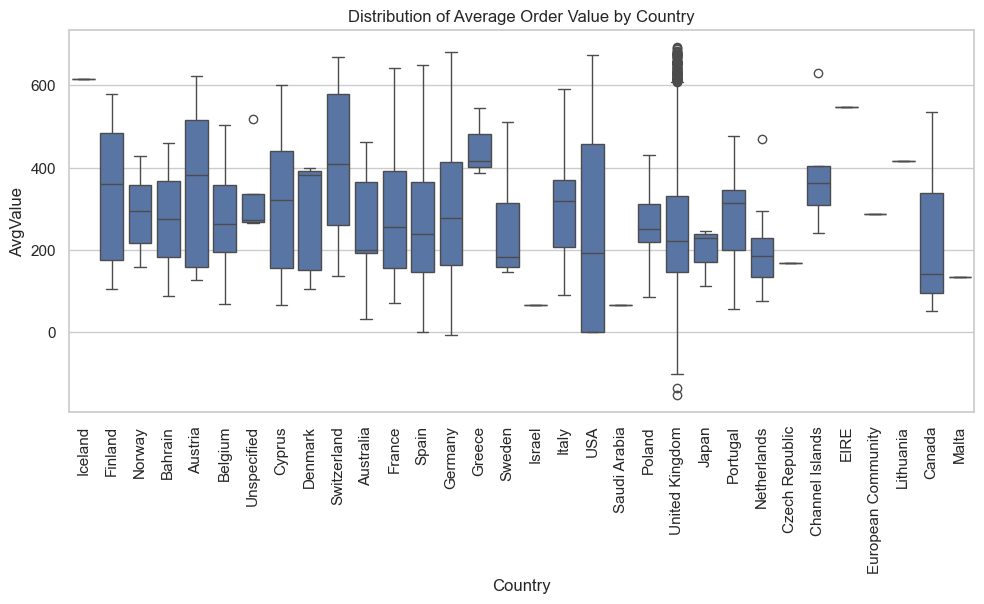

In [77]:
# Average Order Value by country
# AOV will be slightly distorted due to the double-counting of sale-return invoices; but not enough that needs time to be spent on recalculating correclty
create_boxplot(df, 'CustomerID', 'Country', 'InvoiceNo', 'TotalPrice', 'Quantity')
plt.title('Distribution of Average Order Value by Country')
plt.show()

Iceland and EIRE have significantly higher median AOVs, meaning their customers place large orders (possibly bulk buying or fewer but high-value orders).

These countries likely have:

Higher per-order shipping costs, leading customers to consolidate purchases.

B2B buyers instead of typical B2C.

Smaller sample sizes – check if these are driven by a few big customers.

                 Country  AvgValue
4                 Brazil  3.212360
26                   RSA  2.855584
20             Lithuania  2.547638
11    European Community  2.358094
21                 Malta  2.346023
32                   USA  2.152097
6        Channel Islands  2.012568
10                  EIRE  2.009098
23                Norway  1.991587
0              Australia  1.980513
24                Poland  1.975975
18                 Italy  1.925721
2                Bahrain  1.914167
33  United Arab Emirates  1.902123
3                Belgium  1.854231
12               Finland  1.830889
31           Switzerland  1.821823
1                Austria  1.801370
16               Iceland  1.753458
27          Saudi Arabia  1.748933
28             Singapore  1.742528
25              Portugal  1.733748
34        United Kingdom  1.728790
15                Greece  1.655339
13                France  1.654070
17                Israel  1.609581
14               Germany  1.609535
29                 S

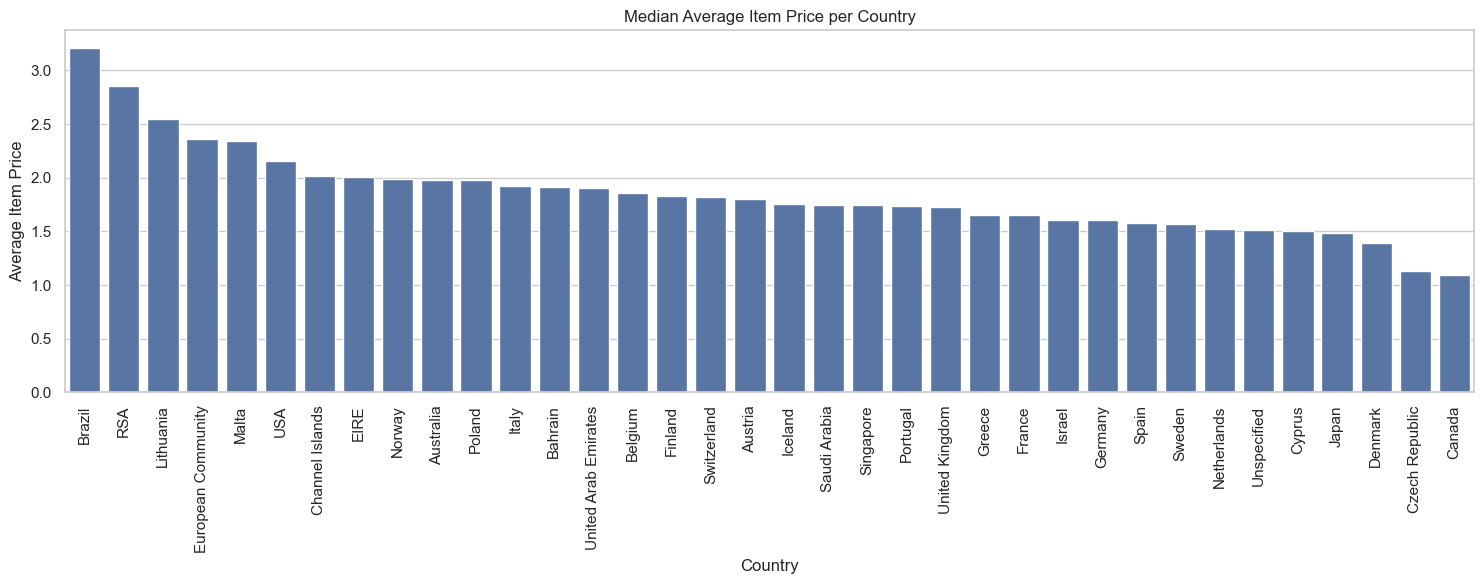

In [79]:
# Average Item Price by country
# AOV will be slightly distorted due to the double-counting of sale-return invoices; but not enough that needs time to be spent on recalculating correclty
create_barplot(df, 'Description')
plt.show()

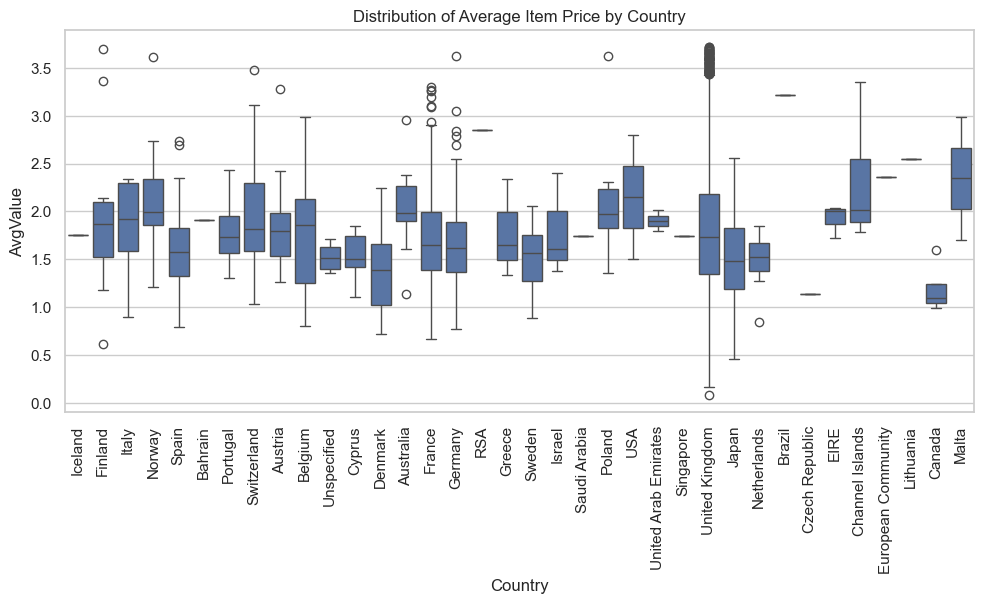

In [63]:
# Average Item Price by Country
create_boxplot(df, 'CustomerID', 'Country', 'Description', 'TotalPrice', 'Quantity')
plt.title('Distribution of Average Item Price by Country')
plt.show()

Brazil and RSA customers pay the highest per item, which could be due to:

Higher product mix (more expensive SKUs).

Fewer discounts or less bundling.

Potentially higher shipping costs affecting pricing.

In contrast, UK (the main market) has an average item price of €1.73, suggesting:

Large volume of inexpensive items.

Possibly more discounting, bundles, or cost-conscious buyers.

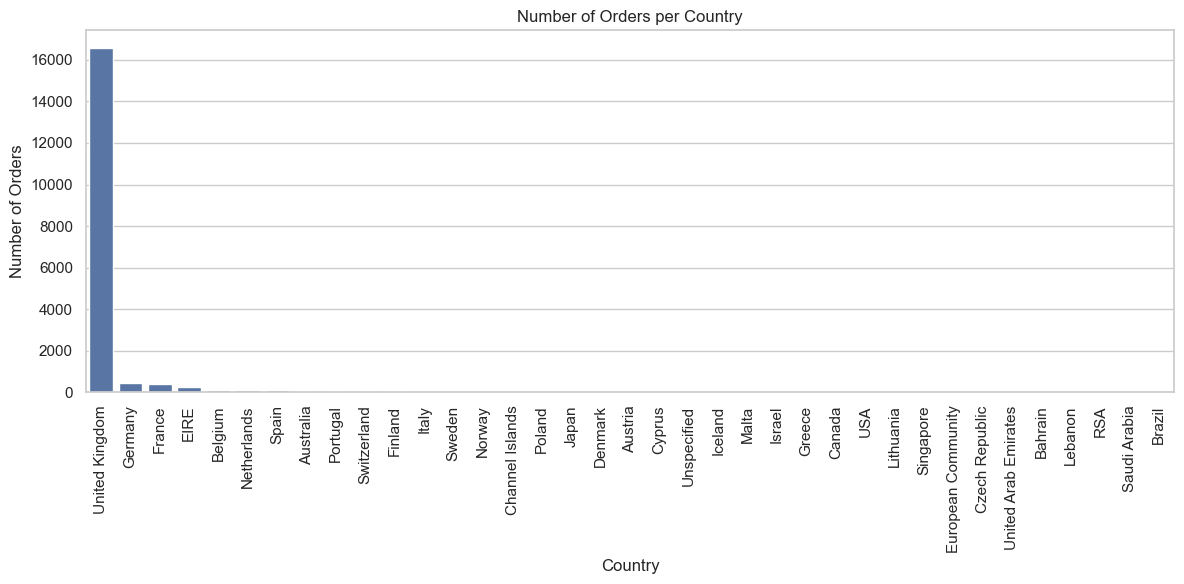

In [250]:
# Group by country and count unique invoices (i.e., orders)
orders_by_country = df[df['Quantity'] > 0].groupby('Country')['InvoiceNo'].nunique().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x=orders_by_country.index, y=orders_by_country.values)
plt.xticks(rotation=90)
plt.title('Number of Orders per Country')
plt.ylabel('Number of Orders')
plt.xlabel('Country')
plt.tight_layout()
plt.show()

### Monthly Revenue trend

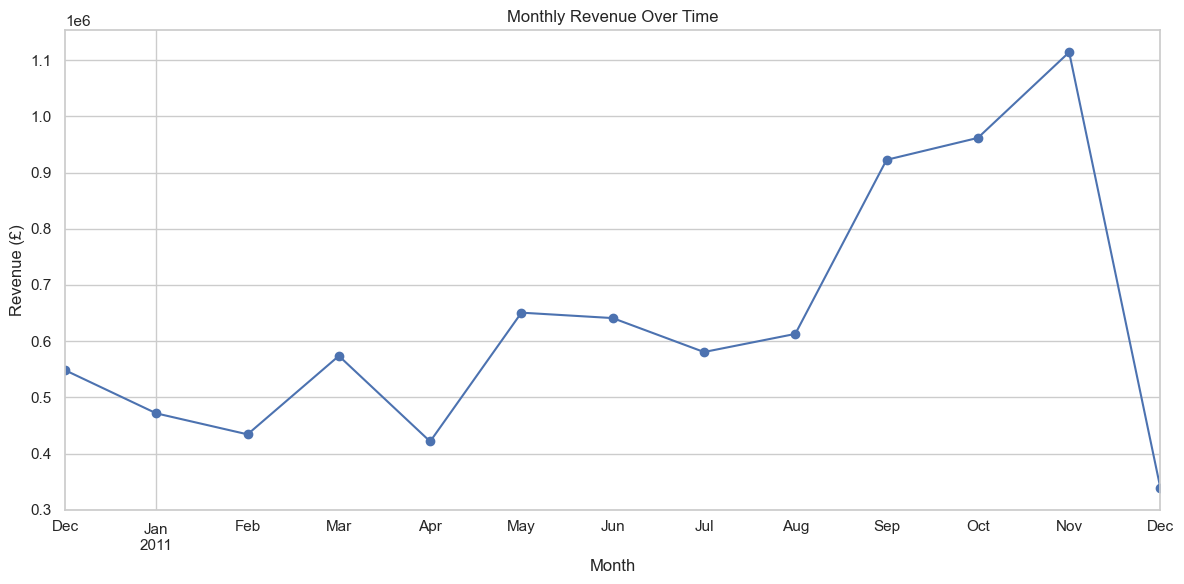

In [83]:
monthly_revenue = df.set_index('InvoiceDate').resample('M')['TotalPrice'].sum()

plt.figure(figsize=(12,6))
monthly_revenue.plot(marker='o')
plt.title("Monthly Revenue Over Time")
plt.ylabel("Revenue (£)")
plt.xlabel("Month")
plt.grid(True)
plt.tight_layout()
plt.show()

### Summary
1. Revenue Summary
    1. Total revenue was £8,272,277.93
    2. Average Order Value: £379.55
    3. Summer sales and black friday are the top revenue drivers
    4. December 2011 dip could be due to data truncation, high returns, or seasonal shutdown.

2. Country-wise Summary
    1. Iceland, EIRE, Greece → highest spend per order (bulk or fewer large transactions).
    2. Brazil, RSA, Lithuania → highest spend per item.
    3. UK, Germany, France → average on both fronts, likely more mass-market behaviour.
    4. Canada, Czech Republic → low AOV and AIP, possibly casual buyers or fewer orders.

3. Product Summary
    1. Top-selling products are PAPER CRAFT, LITTLE BIRDIE, MEDIUM CERAMIC TOP STORAGE JAR and WORLD WAR 2 GLIDERS ASSTD DESIGNS
    2. Different basket interests for the top countries by revenue
    3. White wooden frame sells well together with white wooden antiques
    4. Pink and green regency tea cups and saucers sell well together

## eCom BI Dashboard

Summary of Content:
🧹 Data Cleaning

Returns & Cancellations: Included but handled cleanly to preserve net reporting.
Non-sale Rows: Dropped to improve clarity of commercial performance.

🔍 Exploratory Analysis Highlights

Revenue Summary: Total £8.27M | Avg Order £379.55 | Peaks in Summer & Black Friday | Dec dip explained

Country Analysis:

High AOV: Iceland, EIRE, Greece
High AIP: Brazil, RSA, Lithuania
UK, Germany: Typical mass-market profiles

Product Trends:

Top sellers: Paper Craft, Little Birdie, etc.

Strong product bundling behaviour across countries

📊 Visuals Included

Monthly Revenue Trend
Median AOV by Country
Median AIP by Country
Returns Distribution
Quantity & Unit Price Distribution
Top 5 Products by Revenue

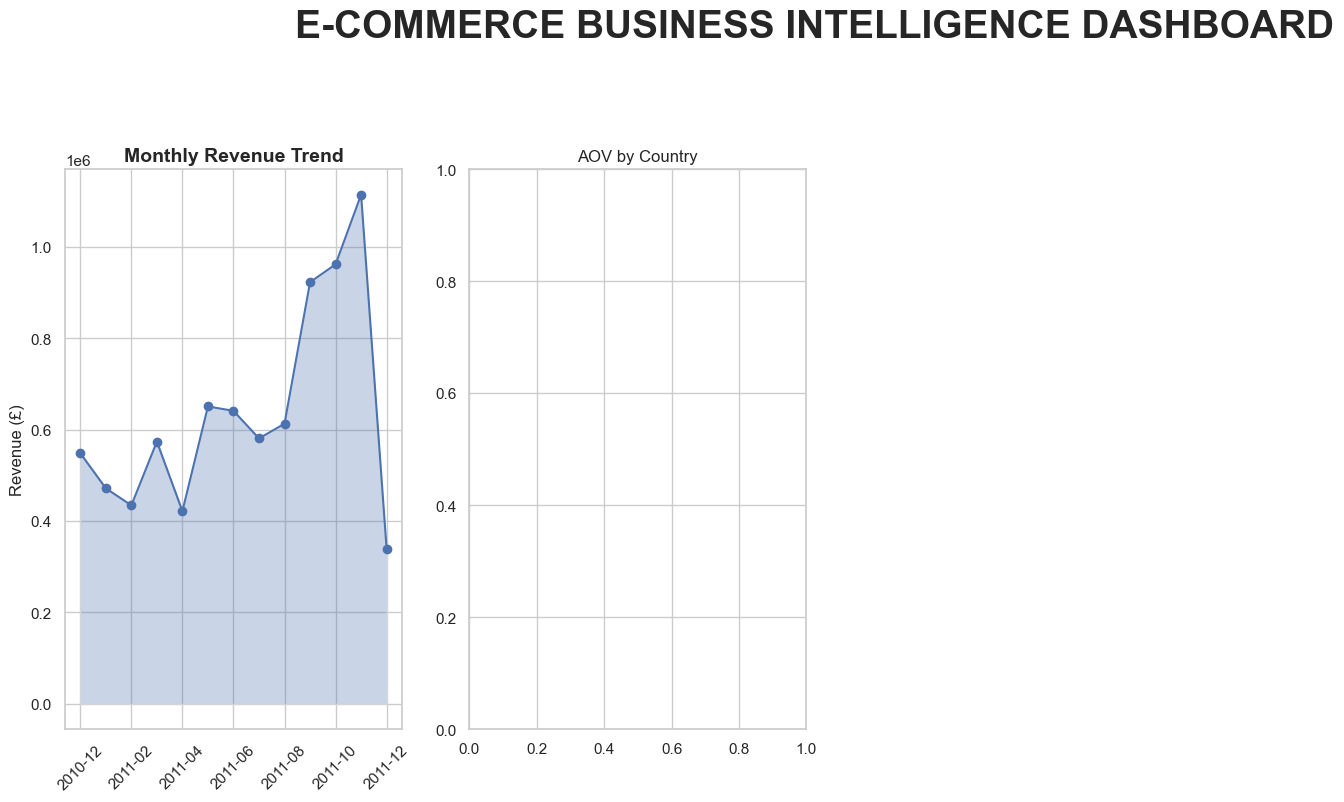

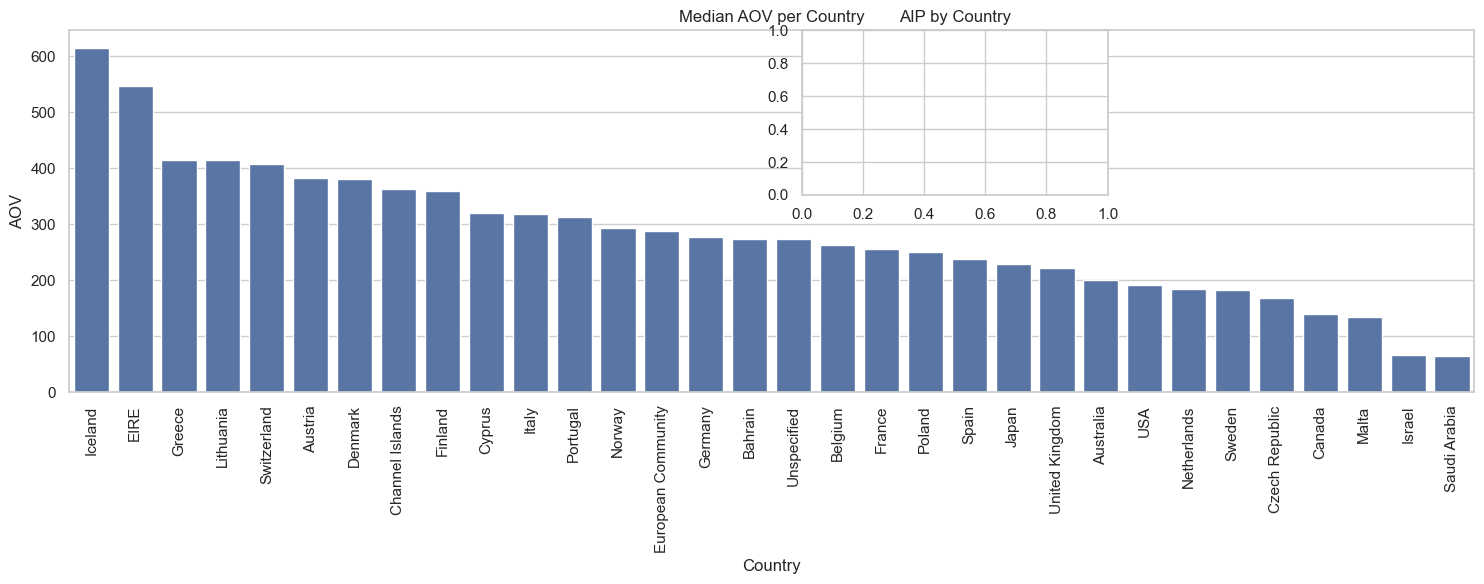

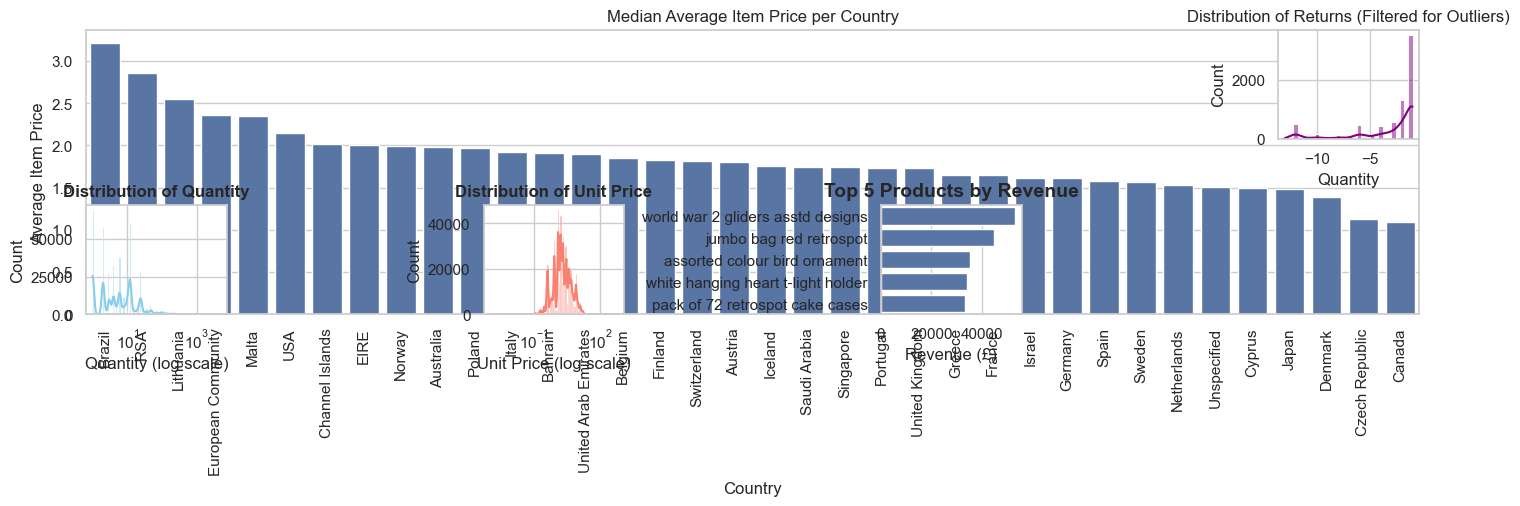

In [120]:
# Set month axis
months = pd.date_range(start="2010-12-01", end="2011-12-31", freq="M").strftime('%Y-%m')

top_products = ['world war 2 gliders asstd designs', 'jumbo bag red retrospot', 'assorted colour bird ornament', 'white hanging heart t-light holder', 'pack of 72 retrospot cake cases']
product_sales = [53119, 44963, 35215, 34128, 33386]

fig = plt.figure(figsize=(20, 16))
fig.suptitle('E-COMMERCE BUSINESS INTELLIGENCE DASHBOARD', fontsize=28, fontweight='bold', y=0.98)

# Panel 1: Monthly Revenue
ax1 = plt.subplot(2, 4, 1)
x = np.arange(len(months))
ax1.plot(x, monthly_revenue.values, marker='o')
ax1.fill_between(x, monthly_revenue.values, alpha=0.3)
ax1.set_title('Monthly Revenue Trend', fontsize=14, fontweight='bold')
ax1.set_xticks(x[::2])
ax1.set_xticklabels(months[::2], rotation=45)
ax1.set_ylabel('Revenue (£)')

# Panel 2: AOV by Country
ax2 = plt.subplot(2, 4, 2)
create_barplot(df, 'InvoiceNo')
ax2.set_title('AOV by Country')

# Panel 3: AIP by Country
ax3 = plt.subplot(2, 4, 3)
create_barplot(df, 'Description')
ax3.set_title('AIP by Country')

# Panel 4: Returns Distribution
ax4 = plt.subplot(2, 4, 4)
sns.histplot(returns_filtered['Quantity'], bins=30, kde=True, color='purple', ax=ax4)
ax4.set_title('Distribution of Returns (Filtered for Outliers)')
ax4.set_xlabel('Quantity')
ax4.set_ylabel('Count')

# Panel 5: Quantity and Unit Price Distributions
ax5a = plt.subplot(2, 4, 5)
sns.histplot(data=df[df['Quantity'] > 0], x='Quantity', bins=100, kde=True, log_scale=(True, False), color='skyblue', ax=ax5a)
ax5a.set_title('Distribution of Quantity', fontsize=12, fontweight='bold')
ax5a.set_xlabel('Quantity (log scale)')
ax5a.set_ylabel('Count')

# Panel 6: Quantity and Unit Price Distributions
ax5b = plt.subplot(2, 4, 6)
sns.histplot(data=df[df['UnitPrice'] > 0], x='UnitPrice', bins=100, kde=True, log_scale=(True, False), color='salmon', ax=ax5b)
ax5b.set_title('Distribution of Unit Price', fontsize=12, fontweight='bold')
ax5b.set_xlabel('Unit Price (log scale)')
ax5b.set_ylabel('Count')

# Panel 6: Top Products by Revenue
ax6 = plt.subplot(2, 4, 7)
sns.barplot(x=product_sales, y=top_products, ax=ax6)
ax6.set_title('Top 5 Products by Revenue', fontsize=14, fontweight='bold')
ax6.set_xlabel('Revenue (£)')

plt.tight_layout()
plt.show()

## RFM Segmentation with K-Means

In [124]:
# Step 1: RFM Calculation (including returns)

# Reference date = 1 day after last invoice
latest_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,   # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'TotalPrice': 'sum'                                       # Monetary (with returns)
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm = rfm[rfm['Monetary'] > 0]  # filter customers with zero or negative net spend

In [128]:
# Step 2: Scaling the Features 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

In [132]:
# Step 3: K-Means Clustering
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

        Recency Frequency  Monetary      
           mean      mean      mean count
Cluster                                  
0          42.3       4.3    1302.3  3042
1         245.7       1.8     480.8  1060
2           5.1     107.4  124845.8    11
3          11.7      27.0   11691.5   208


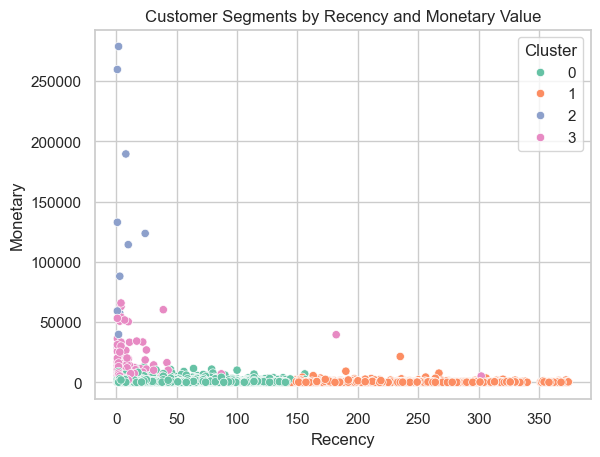

In [138]:
# Step 4: Visualize the Segments
# order clusters by avg monetary value for easier labeling
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)

print(cluster_summary)

# Plot: 2D cluster profile
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='Set2')
plt.title('Customer Segments by Recency and Monetary Value')
plt.show()

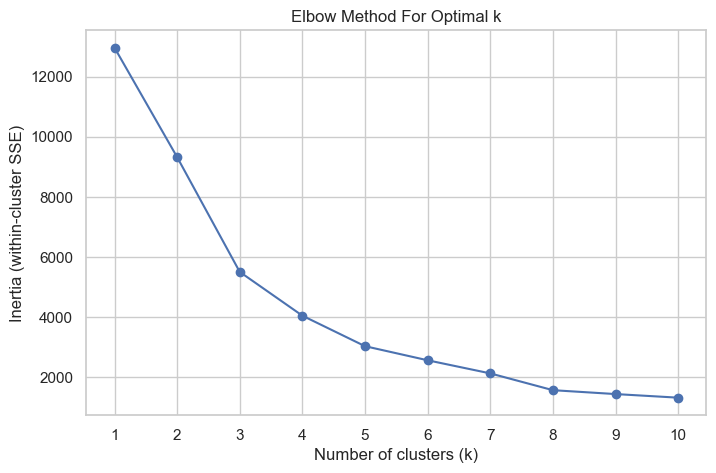

In [140]:
# Elbow method to find the optimal number of clusters
# Run KMeans for a range of cluster numbers and collect inertia
inertia = []
K = range(1, 11)  # Test 1 to 10 clusters

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (within-cluster SSE)')
plt.xticks(K)
plt.grid(True)
plt.show()

In [144]:
inertia

[12963.000000000005,
 9319.879356148367,
 5500.652888528854,
 4043.932336732165,
 3029.1775568556945,
 2560.2257765791423,
 2123.875175013555,
 1565.3212704073865,
 1435.9151520001756,
 1315.9269937288468]